# Install Requirement

In [ ]:
!pip install roboflow
!pip install ultralytics
!pip install matplotlib
!pip install huggingface-hub
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 45.3 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Sat Dec 28 09:03:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import required packages

In [ ]:
import albumentations as A
import cv2
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from IPython import display
import ultralytics
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# YOLOv11 Ultralytics

In [ ]:
display.clear_output()
ultralytics.checks()

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


# Prepare data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data augmentation

In [ ]:
transform = A.Compose(
    [
        A.Rotate(limit=(90, 90), p=1.0),
        A.HorizontalFlip(p=0.5),
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"])
)

In [ ]:
def augment_images(images_dir, labels_dir, save_dir, aug_count=1):
    images_path = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
    labels_path = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

    Path(save_dir / "images").mkdir(parents=True, exist_ok=True)
    Path(save_dir / "labels").mkdir(parents=True, exist_ok=True)

    for img_path, lbl_path in zip(images_path, labels_path):
        image = cv2.imread(img_path)
        height, width, _ = image.shape

        with open(lbl_path, "r") as f:
            boxes = []
            category_ids = []
            for line in f:
                class_id, x, y, w, h = map(float, line.strip().split())
                boxes.append([x, y, w, h])
                category_ids.append(int(class_id))

        for i in range(aug_count):
            augmented = transform(image=image, bboxes=boxes, category_ids=category_ids)
            aug_image = augmented["image"]
            aug_boxes = augmented["bboxes"]
            aug_category_ids = augmented["category_ids"]

            aug_img_filename = f"{Path(img_path).stem}_aug_{i}.jpg"
            aug_img_path = os.path.join(save_dir, "images", aug_img_filename)
            cv2.imwrite(aug_img_path, aug_image)

            aug_lbl_filename = f"{Path(lbl_path).stem}_aug_{i}.txt"
            aug_lbl_path = os.path.join(save_dir, "labels", aug_lbl_filename)
            with open(aug_lbl_path, "w") as f:
                for cat_id, bbox in zip(aug_category_ids, aug_boxes):
                    f.write(f"{cat_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

In [ ]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
augmented_save_dir = Path("/content/drive/MyDrive/AThanh/dataset/augmented/train")

In [ ]:
augment_images(train_images_dir, train_labels_dir, augmented_save_dir, aug_count=2)

## Count the augmented data

In [ ]:
def count_data(images_dir, labels_dir, augmented_dir):
    num_original_images = len(glob.glob(os.path.join(images_dir, "*.jpg")))
    num_original_labels = len(glob.glob(os.path.join(labels_dir, "*.txt")))

    aug_images_dir = os.path.join(augmented_dir, "images")
    aug_labels_dir = os.path.join(augmented_dir, "labels")
    num_augmented_images = len(glob.glob(os.path.join(aug_images_dir, "*.jpg")))
    num_augmented_labels = len(glob.glob(os.path.join(aug_labels_dir, "*.txt")))

    total_images = num_original_images + num_augmented_images
    total_labels = num_original_labels + num_augmented_labels

    print(f"Number of original images: {num_original_images}")
    print(f"Number of original labels: {num_original_labels}")
    print(f"Number of augmented images: {num_augmented_images}")
    print(f"Number of augmented labels: {num_augmented_labels}")
    print(f"Total images (original + augmented): {total_images}")
    print(f"Total labels (original + augmented): {total_labels}")

In [ ]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
augmented_save_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train"

In [ ]:
count_data(train_images_dir, train_labels_dir, augmented_save_dir)

Number of original images: 521
Number of original labels: 521
Number of augmented images: 1042
Number of augmented labels: 1042
Total images (original + augmented): 1563
Total labels (original + augmented): 1563


In [ ]:
def plot_image_with_boxes(image_path, label_path, title):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    with open(label_path, "r") as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.strip().split())
            x1 = int((x - w / 2) * width)
            y1 = int((y - h / 2) * height)
            x2 = int((x + w / 2) * width)
            y2 = int((y + h / 2) * height)
            color = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f"Class {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

In [ ]:
def display_original_with_augmented_pairs(original_images_dir, original_labels_dir, augmented_images_dir, augmented_labels_dir, num_examples=5):
    original_images = sorted(list(Path(original_images_dir).glob("*.jpg")))[:num_examples]

    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

    for i, orig_img_path in enumerate(original_images):
        orig_lbl_path = Path(original_labels_dir) / f"{orig_img_path.stem}.txt"

        plt.subplot(num_examples, 3, 3 * i + 1)
        plot_image_with_boxes(str(orig_img_path), str(orig_lbl_path), title="Original")

        aug_images = sorted(Path(augmented_images_dir).glob(f"{orig_img_path.stem}_aug_*.jpg"))
        for j, aug_img_path in enumerate(aug_images[:2]):
            aug_lbl_path = Path(augmented_labels_dir) / f"{aug_img_path.stem}.txt"
            plt.subplot(num_examples, 3, 3 * i + 2 + j)
            plot_image_with_boxes(str(aug_img_path), str(aug_lbl_path), title=f"Augmented {j + 1}")

    plt.tight_layout()
    plt.show()

In [ ]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
aug_images_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train/images"
aug_labels_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train/labels"

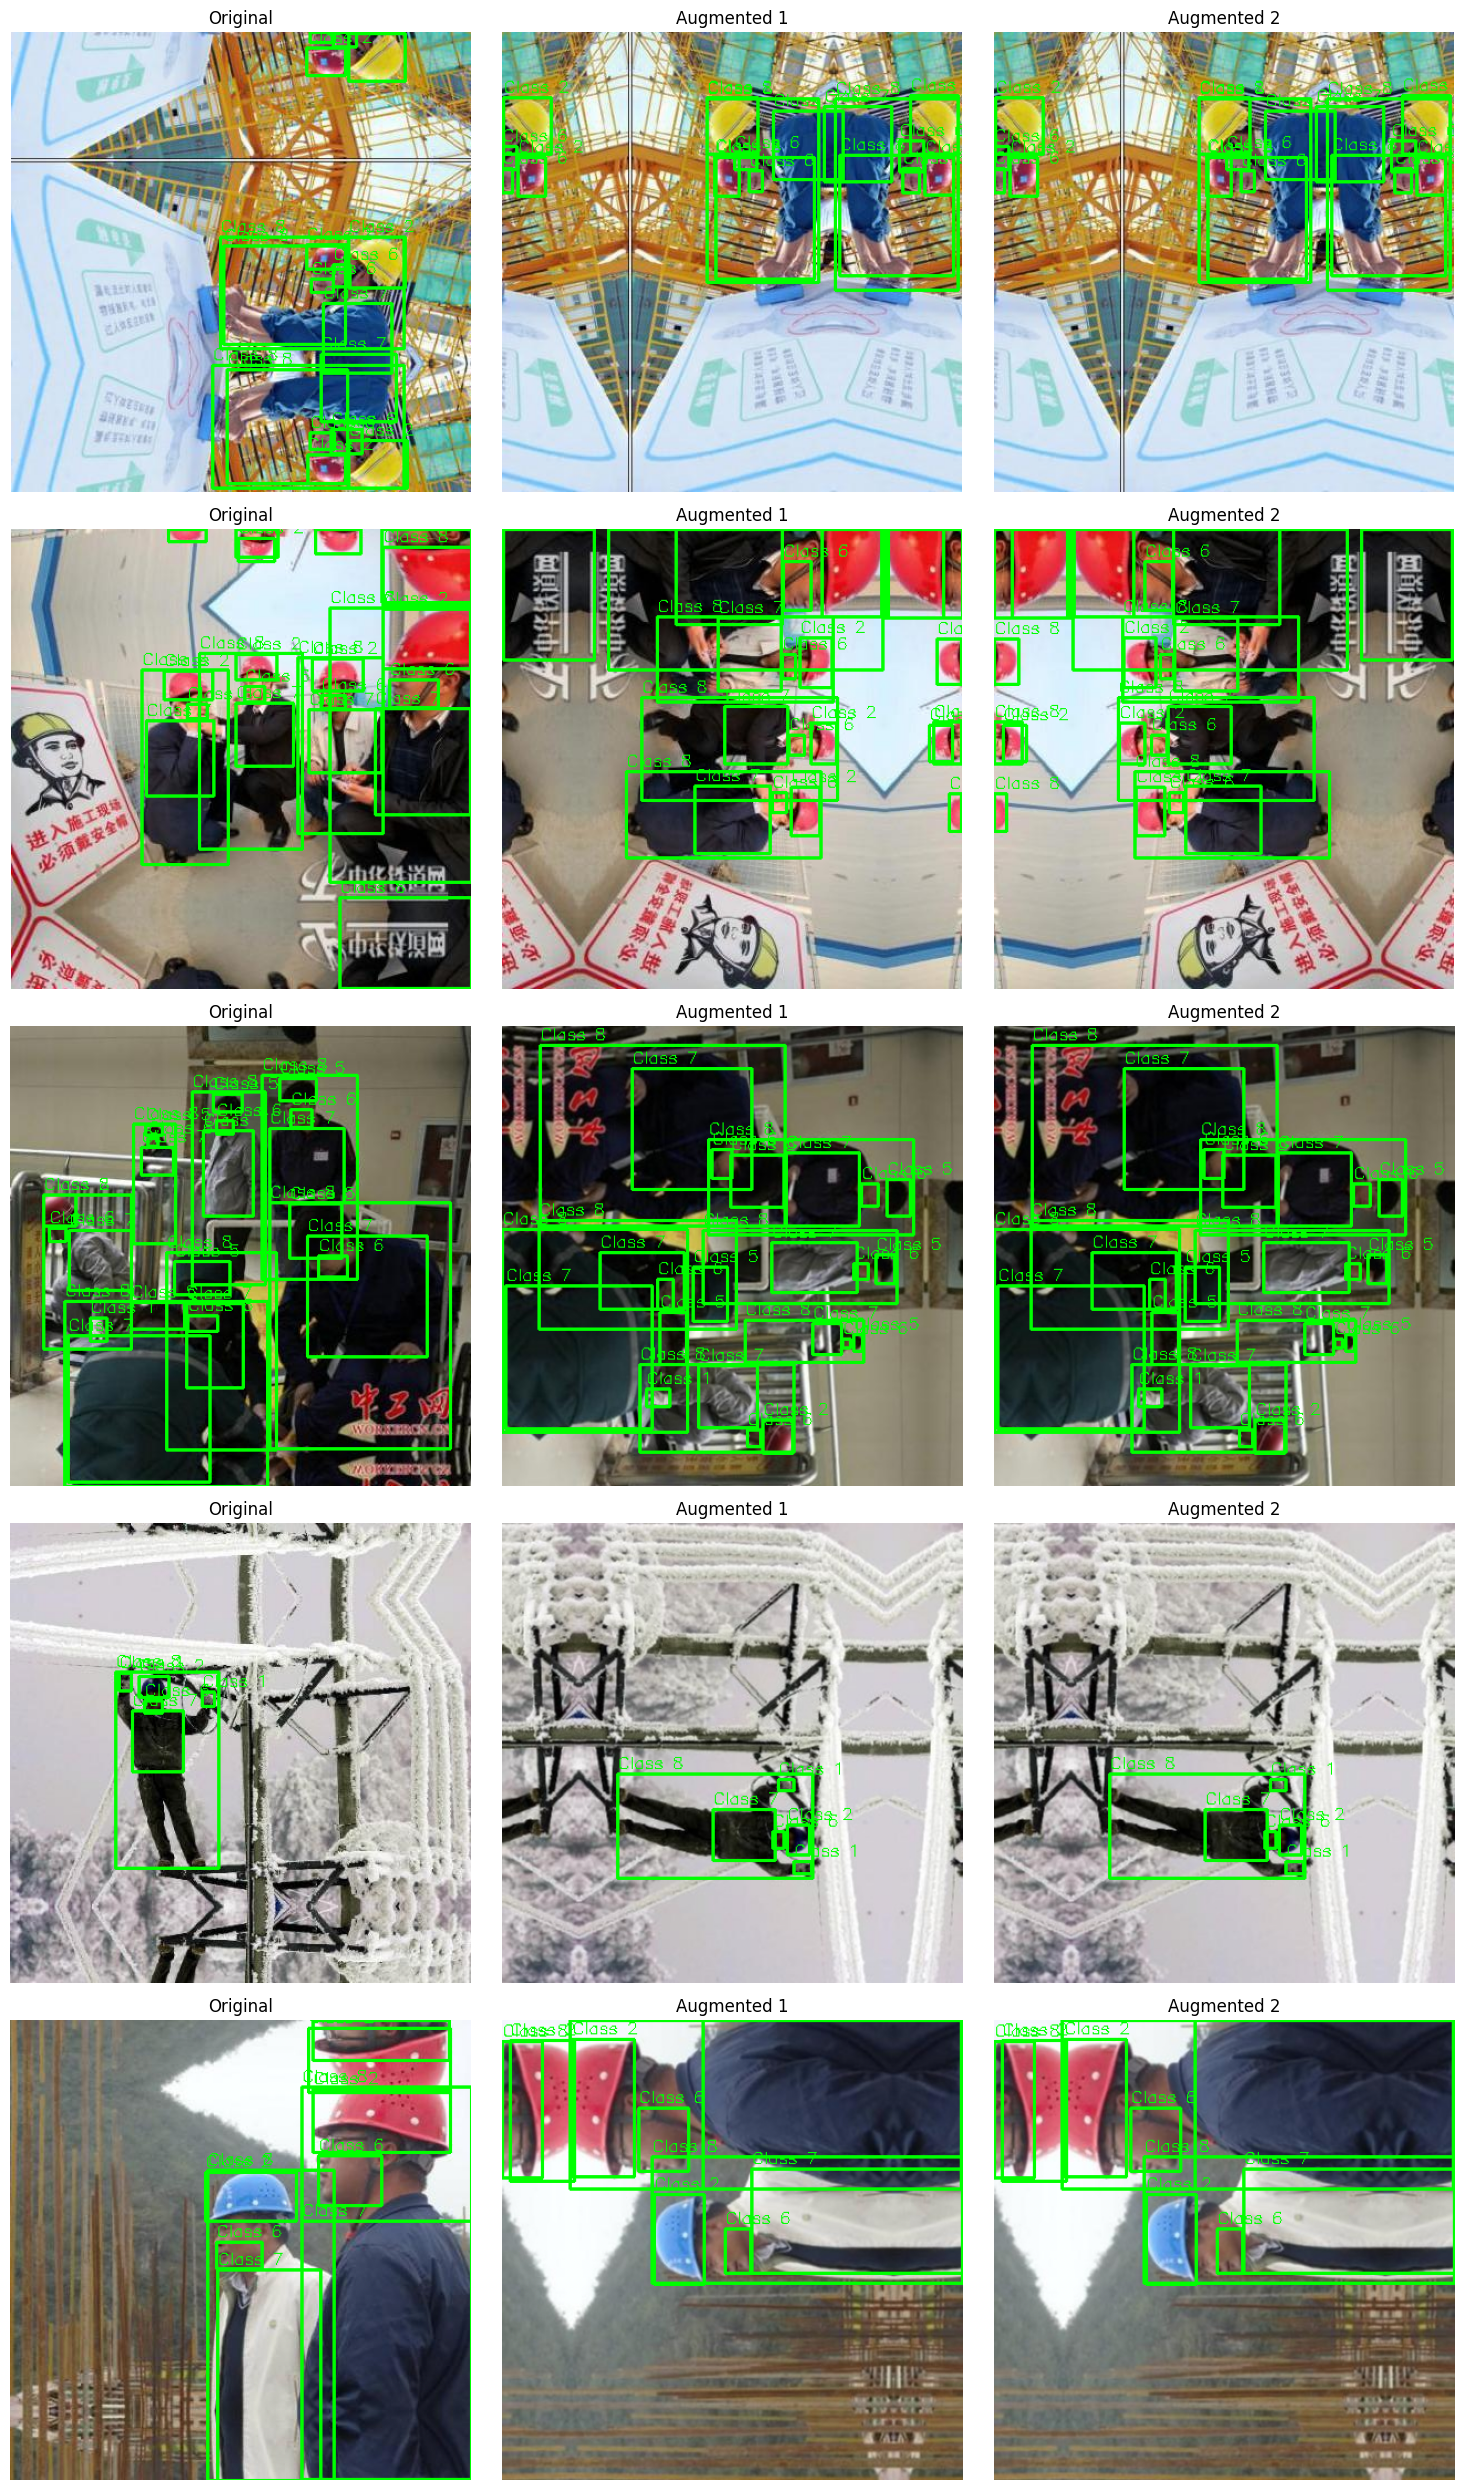

In [ ]:
display_original_with_augmented_pairs(train_images_dir, train_labels_dir, aug_images_dir, aug_labels_dir, num_examples=5)

## Generate YAML configuration file

In [ ]:
CLASS_NAMES = ['Excavator', 'Gloves', 'Hardhat', 'Ladder', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'SUV', 'Safety Cone', 'Safety Vest', 'bus', 'dump truck', 'fire hydrant', 'machinery', 'mini-van', 'sedan', 'semi', 'trailer', 'truck', 'truck and trailer', 'van', 'vehicle', 'wheel loader']

In [ ]:
import yaml
from pathlib import Path

def create_yaml_file(dataset_path, train_images, val_images, test_images=None, class_names=CLASS_NAMES):
    data = {
        'path': str(dataset_path),
        'train': str(Path(train_images).relative_to(dataset_path)),
        'val': str(Path(val_images).relative_to(dataset_path)),
    }

    if test_images:
        data['test'] = str(Path(test_images).relative_to(dataset_path))

    data['nc'] = len(class_names)
    data['names'] = class_names

    yaml_path = Path(dataset_path) / 'dataset.yaml'
    with open(yaml_path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

    print(f"YAML file created at {yaml_path}")

In [ ]:
dataset_root = Path("/content/drive/MyDrive/AThanh/dataset")
train_images_dir = dataset_root / "train/images"
val_images_dir = dataset_root / "valid/images"
test_images_dir = dataset_root / "test/images"

In [ ]:
create_yaml_file(dataset_root, train_images_dir, val_images_dir, test_images_dir, class_names=CLASS_NAMES)

YAML file created at /content/drive/MyDrive/AThanh/dataset/dataset.yaml


# Train YOLOv11 model

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
model = YOLO("yolo11n.pt")

results = model.train(
    data="/content/drive/MyDrive/AThanh/dataset/dataset.yaml",
    epochs=50,
    batch=16,
    lr0=1e-4,
    imgsz=640,
)

metrics = model.val()

print(metrics)

100%|██████████| 5.35M/5.35M [00:00<00:00, 262MB/s]

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/AThanh/dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, o

100%|██████████| 755k/755k [00:00<00:00, 89.7MB/s]


Overriding model.yaml nc=80 with nc=25

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/drive/MyDrive/AThanh/dataset/train/labels.cache... 521 images, 34 backgrounds, 0 corrupt: 100%|██████████| 521/521 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/AThanh/dataset/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000345, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.24G      1.361      4.454      1.401        116        640: 100%|██████████| 33/33 [00:26<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]

                   all        114        733          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.47G      1.316      4.085      1.341         83        640: 100%|██████████| 33/33 [00:15<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        114        733     0.0682      0.126     0.0944     0.0654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.98G      1.385      3.607       1.36         83        640: 100%|██████████| 33/33 [00:14<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        114        733       0.63      0.167       0.18      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.51G      1.423       3.06      1.407        146        640: 100%|██████████| 33/33 [00:14<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        114        733      0.616        0.2      0.217      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.77G      1.424      2.705      1.398        109        640: 100%|██████████| 33/33 [00:13<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        114        733      0.603      0.229      0.248      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.9G      1.375      2.437      1.348         92        640: 100%|██████████| 33/33 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        114        733      0.696      0.268      0.296       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.04G      1.315      2.106      1.328        108        640: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        114        733      0.743      0.292      0.318      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.21G      1.335      2.031       1.33         97        640: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        114        733      0.763      0.311       0.36      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.81G      1.298      1.935      1.302        117        640: 100%|██████████| 33/33 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        733      0.674      0.331      0.359      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.62G      1.238       1.79      1.283        132        640: 100%|██████████| 33/33 [00:13<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        114        733      0.815      0.308      0.378       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.21G      1.243      1.708      1.288        107        640: 100%|██████████| 33/33 [00:13<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        114        733      0.774      0.302      0.376      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.11G      1.223      1.685      1.271         90        640: 100%|██████████| 33/33 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        114        733      0.668      0.334      0.389      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.54G      1.224      1.612      1.257         70        640: 100%|██████████| 33/33 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

                   all        114        733       0.64      0.334      0.378      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.15G      1.231      1.632      1.265         81        640: 100%|██████████| 33/33 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        114        733      0.715      0.337      0.391      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.33G      1.187      1.513      1.227        143        640: 100%|██████████| 33/33 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        114        733      0.688      0.346      0.395      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.24G      1.172      1.505      1.243        146        640: 100%|██████████| 33/33 [00:14<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        114        733      0.688      0.396      0.433      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.99G      1.147      1.455      1.237         91        640: 100%|██████████| 33/33 [00:15<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        114        733      0.588      0.442      0.445      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.25G      1.159      1.425      1.209        174        640: 100%|██████████| 33/33 [00:14<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        733       0.59       0.42      0.416       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.41G      1.147      1.373      1.212        117        640: 100%|██████████| 33/33 [00:15<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        114        733      0.701        0.4      0.432      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.76G      1.107      1.399      1.196        116        640: 100%|██████████| 33/33 [00:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        114        733      0.713      0.391      0.428      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.02G      1.085      1.333      1.179        107        640: 100%|██████████| 33/33 [00:14<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        114        733      0.658       0.44      0.455      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.07G      1.106      1.327      1.198        114        640: 100%|██████████| 33/33 [00:14<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        114        733      0.672      0.431      0.463      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.32G      1.065      1.339      1.189         50        640: 100%|██████████| 33/33 [00:14<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        114        733      0.592       0.43      0.444      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.96G       1.07      1.313      1.175         91        640: 100%|██████████| 33/33 [00:15<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        114        733      0.666      0.421      0.473      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.79G      1.061      1.325      1.189        222        640: 100%|██████████| 33/33 [00:15<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        114        733       0.63      0.432      0.471      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.06G      1.044      1.251      1.174         93        640: 100%|██████████| 33/33 [00:15<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        114        733      0.605       0.44      0.453      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.86G      1.018      1.249      1.152        109        640: 100%|██████████| 33/33 [00:14<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        114        733      0.738      0.396      0.452      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.13G      1.043      1.212      1.167         89        640: 100%|██████████| 33/33 [00:14<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        114        733      0.697      0.437      0.473      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.13G      1.036      1.227      1.151        174        640: 100%|██████████| 33/33 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        114        733      0.758      0.404      0.468      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.04G      1.006      1.183      1.158         81        640: 100%|██████████| 33/33 [00:14<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        114        733      0.668      0.446      0.471      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.24G      1.033      1.191      1.141         84        640: 100%|██████████| 33/33 [00:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        114        733        0.7      0.419       0.46      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.11G     0.9899      1.157      1.138        152        640: 100%|██████████| 33/33 [00:13<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        114        733      0.705      0.424      0.461      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.3G      0.985      1.123       1.13         96        640: 100%|██████████| 33/33 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        114        733      0.733      0.412      0.468       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.09G      1.029      1.165      1.136        105        640: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        114        733       0.75      0.414      0.462      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.43G      0.987      1.122      1.129         97        640: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        114        733      0.746      0.426      0.468      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.14G     0.9737      1.122      1.127        134        640: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        114        733      0.709      0.439       0.47      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.94G     0.9524      1.081      1.108         95        640: 100%|██████████| 33/33 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        114        733      0.761      0.413      0.465      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.14G     0.9764      1.088      1.094        131        640: 100%|██████████| 33/33 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        114        733      0.744      0.423      0.476      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.28G     0.9743      1.099      1.108        104        640: 100%|██████████| 33/33 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        114        733      0.764      0.419      0.481      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.79G     0.9468      1.081      1.113        173        640: 100%|██████████| 33/33 [00:14<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        114        733      0.764      0.424      0.487       0.33


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.06G      0.978      1.216      1.105        129        640: 100%|██████████| 33/33 [00:16<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


                   all        114        733      0.775      0.414      0.481      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.06G     0.9728      1.171      1.095        110        640: 100%|██████████| 33/33 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        114        733      0.712      0.427      0.486      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.26G     0.9364      1.123      1.082        165        640: 100%|██████████| 33/33 [00:14<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

                   all        114        733      0.754      0.441      0.492      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.91G      0.937        1.1      1.084         60        640: 100%|██████████| 33/33 [00:15<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        114        733      0.782      0.421      0.487      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.23G     0.9071      1.101      1.054         43        640: 100%|██████████| 33/33 [00:16<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        114        733      0.775      0.421      0.488      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.15G     0.8964      1.066      1.047         52        640: 100%|██████████| 33/33 [00:14<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        114        733      0.751      0.431      0.488      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.96G     0.9117      1.074      1.066         52        640: 100%|██████████| 33/33 [00:14<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


                   all        114        733      0.758      0.421      0.487      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.01G      0.904      1.074       1.06         35        640: 100%|██████████| 33/33 [00:16<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


                   all        114        733      0.738      0.433      0.487      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.11G     0.9068      1.058       1.06         58        640: 100%|██████████| 33/33 [00:14<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

                   all        114        733      0.754      0.434      0.488      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.99G     0.8904      1.043      1.051        134        640: 100%|██████████| 33/33 [00:14<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        114        733      0.746      0.439      0.487      0.326



50 epochs completed in 0.252 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,587,027 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


                   all        114        733       0.76      0.425      0.487       0.33
             Excavator         10         12      0.606      0.667      0.715      0.642
                Gloves         11         25      0.738       0.36      0.356      0.167
               Hardhat         42         79       0.88      0.556      0.715      0.508
                Ladder          8         10      0.459        0.6      0.528      0.426
                  Mask         19         21      0.954       0.81      0.853      0.571
            NO-Hardhat         37         69      0.796      0.508      0.613      0.304
               NO-Mask         44         74      0.803      0.351       0.47      0.166
        NO-Safety Vest         56        106      0.796      0.557      0.622      0.375
                Person         84        166      0.833      0.692      0.764      0.561
           Safety Cone         13         44      0.807      0.818      0.815      0.417
           Safety Ves

val: Scanning /content/drive/MyDrive/AThanh/dataset/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


                   all        114        733      0.768      0.424      0.489       0.33
             Excavator         10         12      0.569      0.667      0.713       0.64
                Gloves         11         25      0.748       0.36      0.359      0.174
               Hardhat         42         79      0.879      0.553      0.716      0.504
                Ladder          8         10      0.498        0.6      0.537      0.433
                  Mask         19         21      0.955       0.81      0.851      0.576
            NO-Hardhat         37         69      0.815      0.507      0.623      0.305
               NO-Mask         44         74       0.85      0.351      0.493      0.168
        NO-Safety Vest         56        106      0.807      0.552      0.628       0.38
                Person         84        166      0.832      0.687      0.763       0.56
           Safety Cone         13         44      0.814      0.818      0.815      0.416
           Safety Ves

                             Metric     Value
0  Mean Average Precision (mAP@0.5)  0.488642
1                         Precision  0.768398
2                            Recall  0.423509


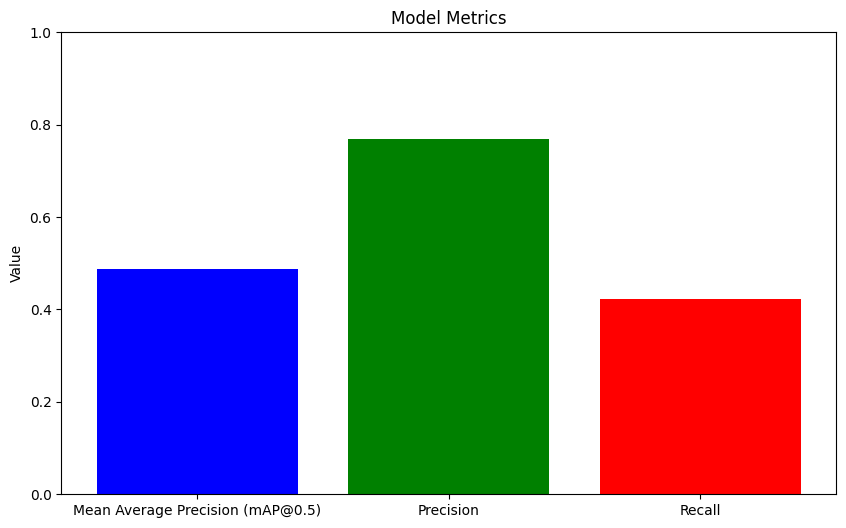

In [ ]:
mAP50 = metrics.results_dict.get('metrics/mAP50(B)', 0)
precision = metrics.results_dict.get('metrics/precision(B)', 0)
recall = metrics.results_dict.get('metrics/recall(B)', 0)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Average Precision (mAP@0.5)",
               "Precision", "Recall"],
    "Value": [mAP50, precision, recall]
})

print(metrics_df)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df["Metric"], metrics_df["Value"], color=['blue', 'green', 'red'])
plt.title("Model Metrics")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.show()

# Exporting model to Hugging Face

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")

model.export(format="onnx")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 238 layers, 2,587,027 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 29, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 264.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 296.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 330.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 257.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 270.6 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 20.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for up

'runs/detect/train/weights/best.onnx'

## Deploy model on Hugging Face

In [ ]:
from huggingface_hub import HfApi, HfFolder, Repository
import locale

In [ ]:
# Define a function to override the default locale setting with UTF-8. This comes from search result [2]
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

In [ ]:
# Override locale settings
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `luanle13` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate

In [ ]:
from huggingface_hub import create_repo, upload_file

repo_id = "ltl1313ltl/construction-safety"

upload_file(
    path_or_fileobj="runs/detect/train/weights/best.pt",
    path_in_repo="model.pt",
    repo_id=repo_id,
    repo_type="model"
)

print(f"Model uploaded!")

best.pt:   0%|          | 0.00/5.46M [00:00<?, ?B/s]

Model uploaded!



image 1/1 /content/pic3.png: 448x640 10 Hardhats, 7 NO-Masks, 10 NO-Safety Vests, 10 Persons, 50.0ms
Speed: 2.1ms preprocess, 50.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


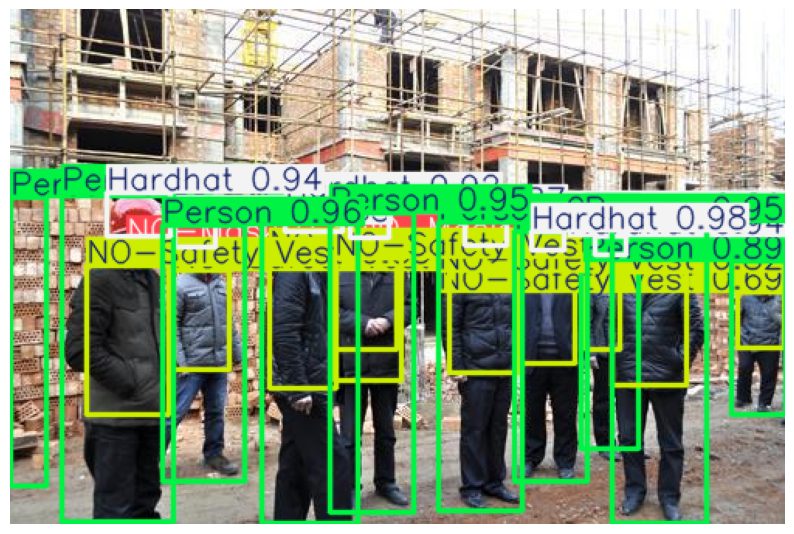

In [ ]:
trained_model = YOLO('/content/runs/detect/train/weights/best.pt')

test_image_path = '/content/pic3.png'

results = trained_model.predict(test_image_path, save=True, save_txt=True)

for result in results:
    img = result.plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()